# DINEOF

In [1]:
import autoroot
from jaxtyping import Float, Array
import numpy as np
import xarray_einstats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import pandas as pd
import einx
from tqdm.auto import trange, tqdm
from sklearn.utils.extmath import randomized_svd, _randomized_eigsh
from da_toolz._src.ops.covariance import localize_covariance
from da_toolz._src.models.pca import pod_temporal_reconstruction, pod_spatial_reconstruction
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data

In [2]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
# change units
# ds = ds.sel(time=slice("2013-01-01", "2013-02-01"))
ds["air"] = ds.air - 273.15

### Rearrange Data

In [4]:
# tranpose
ds = ds.transpose("time", "lon", "lat")
ds = ds.stack(spatial=["lon", "lat"])

In [5]:
n_space = ds.spatial.shape[0]
n_time = ds.time.shape[0]

In [6]:
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (time: 2920, spatial: 1325)
Coordinates:
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
  * spatial  (spatial) object 11kB MultiIndex
  * lon      (spatial) float32 5kB 200.0 200.0 200.0 200.0 ... 330.0 330.0 330.0
  * lat      (spatial) float32 5kB 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
Data variables:
    air      (time, spatial) float64 31MB -31.95 -29.35 -23.15 ... 22.04 22.54
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### PCA

In [7]:
X = ds.air.values.T
n_components = None

clf = PCA(n_components=n_components, random_state=42)
clf.fit(X=X)

X_red = clf.transform(X)
X_recon = clf.inverse_transform(X_red)

In [8]:
X_recon.shape

(1325, 2920)

In [9]:
ds["air_recon"] = (("spatial", "time" ), X_recon)

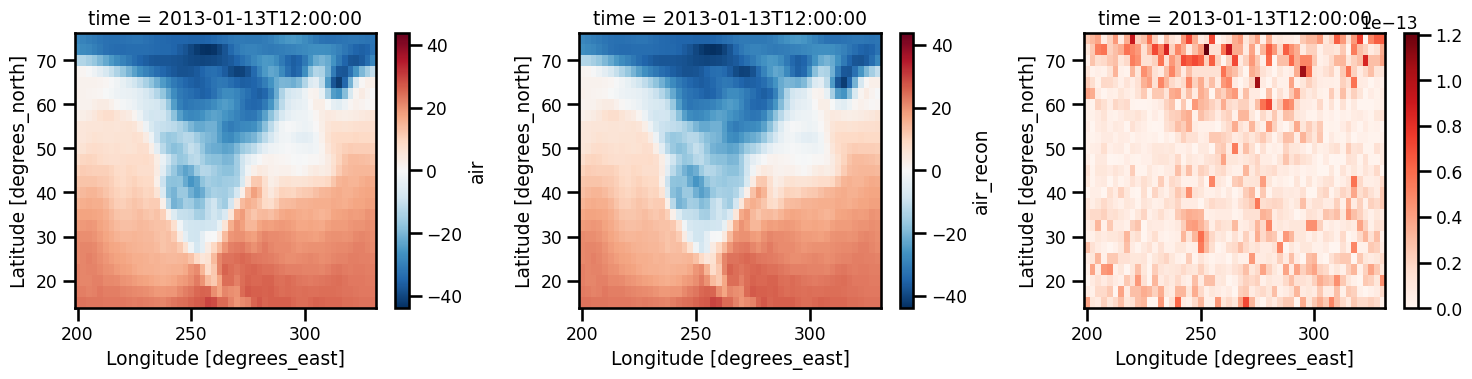

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 50

ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
ds.air_recon.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(ds.air - ds.air_recon).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

## Missing Data

In [212]:
def set_random_fraction_to_nan(data):
    data[np.random.rand(*data.shape) < .4]=np.nan
    return data

In [213]:
ds["air_obs"] = ds["air"].copy()

In [214]:
ds

<xarray.Dataset> Size: 93MB
Dimensions:    (time: 2920, spatial: 1325)
Coordinates:
  * time       (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
  * spatial    (spatial) object 11kB MultiIndex
  * lon        (spatial) float32 5kB 200.0 200.0 200.0 ... 330.0 330.0 330.0
  * lat        (spatial) float32 5kB 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
Data variables:
    air        (time, spatial) float64 31MB -31.95 -29.35 -23.15 ... 22.04 22.54
    air_recon  (spatial, time) float64 31MB -31.95 -31.05 -30.85 ... 22.04 22.54
    air_obs    (time, spatial) float64 31MB -31.95 -29.35 -23.15 ... 22.04 22.54
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [215]:
# Set 80% of data randomly to nan
dims = ['time','spatial']
ds["air_obs"] = xr.apply_ufunc(set_random_fraction_to_nan, ds["air_obs"], input_core_dims=[dims],output_core_dims=[dims], dask='parallelized')

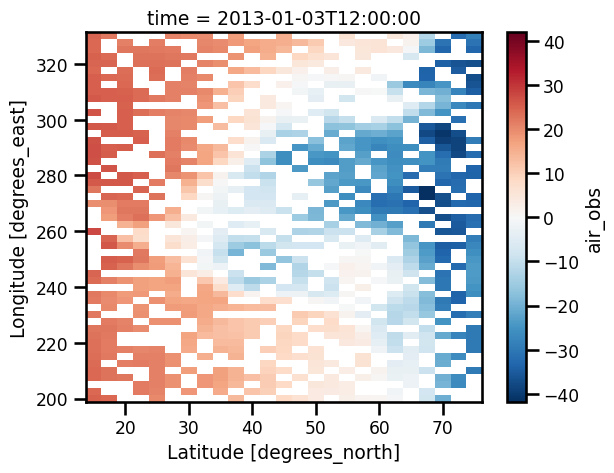

In [216]:
ds.air_obs.unstack().isel(time=itime).plot.pcolormesh()

## Initial Condition

In [217]:
data = ds["air_obs"]

data = data.transpose("spatial", "time")

In [218]:
nan_mask = np.isnan(data)
non_nan_mask = ~nan_mask

# data = data.fillna(value=0.0)
# data = data.interpolate_na(dim="time", method="linear", fill_value="extrapolate")

In [219]:
import os

import numpy as np
from scipy.linalg import orth


class PPCA():

    def __init__(self):

        self.raw = None
        self.data = None
        self.C = None
        self.means = None
        self.stds = None
        self.eig_vals = None

    def _standardize(self, X):

        if self.means is None or self.stds is None:
            raise RuntimeError("Fit model first")

        return (X - self.means) / self.stds

    def unstandardize(self, X):

        if self.means is None or self.stds is None:
            raise RuntimeError("Fit model first")

        return X * self.stds + self.means

    def fit(self, data, d=None, tol=1e-4, min_obs=10, verbose=False, max_iteration=10):

        self.raw = data
        self.raw[np.isinf(self.raw)] = np.max(self.raw[np.isfinite(self.raw)])

        valid_series = np.sum(~np.isnan(self.raw), axis=0) >= min_obs

        data = self.raw[:, valid_series].copy()
        N = data.shape[0]
        D = data.shape[1]

        self.means = np.nanmean(data, axis=0)
        self.stds = np.nanstd(data, axis=0)

        data = self._standardize(data)
        observed = ~np.isnan(data)
        missing = np.sum(~observed)
        data[~observed] = 0

        # initial

        if d is None:
            d = data.shape[1]
        if self.C is None:
            C = np.random.randn(D, d)
        else:
            C = self.C
        CC = np.dot(C.T, C)
        X = np.dot(np.dot(data, C), np.linalg.inv(CC))
        print(CC.shape, X.shape)
        recon = np.dot(X, C.T)
        recon[~observed] = 0
        ss = np.sum((recon - data)**2)/(N*D - missing)

        v0 = np.inf
        counter = 0
        pbar = trange(max_iteration)
        recon_filled = 0.0
        for iteration in pbar:

            Sx = np.linalg.inv(np.eye(d) + CC/ss)

            # e-step
            ss0 = ss
            if missing > 0:
                proj = np.dot(X, C.T)
                data[~observed] = proj[~observed]
            X = np.dot(np.dot(data, C), Sx) / ss

            # m-step
            XX = np.dot(X.T, X)
            C = np.dot(np.dot(data.T, X), np.linalg.pinv(XX + N*Sx))
            CC = np.dot(C.T, C)
            recon = np.dot(X, C.T)
            recon_filled = recon.copy()

            recon[~observed] = 0
            ss = (np.sum((recon-data)**2) + N*np.sum(CC*Sx) + missing*ss0)/(N*D)

            # calc diff for convergence
            det = np.log(np.linalg.det(Sx))
            if np.isinf(det):
                det = abs(np.linalg.slogdet(Sx)[1])
            v1 = N*(D*np.log(ss) + np.trace(Sx) - det) \
                + np.trace(XX) - missing*np.log(ss0)
            diff = abs(v1/v0 - 1)

            pbar.set_description(f"Diff: {diff:.5e}")

            if (diff < tol) and (counter > 5):
                break

            counter += 1
            v0 = v1


        print(C.shape)
        # C = orth(C)
        print(C.shape)
        vals, vecs = np.linalg.eig(np.cov(np.dot(data, C).T))
        print(vals.shape)
        order = np.flipud(np.argsort(vals))
        vecs = vecs[:, order]
        vals = vals[order]

        C = np.dot(C, vecs)

        # attach objects to class
        self.C = C
        self.data = data
        self.eig_vals = vals
        self.recon = recon_filled
        self._calc_var()

    def transform(self, data=None):

        if self.C is None:
            raise RuntimeError('Fit the data model first.')
        if data is None:
            return np.dot(self.data, self.C)
        return np.dot(data, self.C)

    def _calc_var(self):

        if self.data is None:
            raise RuntimeError('Fit the data model first.')

        data = self.data.T

        # variance calc
        var = np.nanvar(data, axis=1)
        total_var = var.sum()
        self.var_exp = self.eig_vals.cumsum() / total_var

    def save(self, fpath):

        np.save(fpath, self.C)
        
    def load(self, fpath):

        assert os.path.isfile(fpath)

        self.C = np.load(fpath)

In [220]:
X = data.values.copy()

In [221]:
ppca_model = PPCA()
ppca_model.fit(data=X.copy(), d=20, tol=1e-4, max_iteration=500, verbose=True)

(20, 20) (1325, 20)


  0%|          | 0/500 [00:00<?, ?it/s]

(2920, 20)
(2920, 20)
(20,)


In [222]:
components = ppca_model.C
components.shape

(2920, 20)

In [223]:
X_recon = ppca_model.unstandardize(ppca_model.recon)
X_recon.shape

(1325, 2920)

In [224]:
data["recon_ppca"] = (("spatial", "time", ), X_recon)

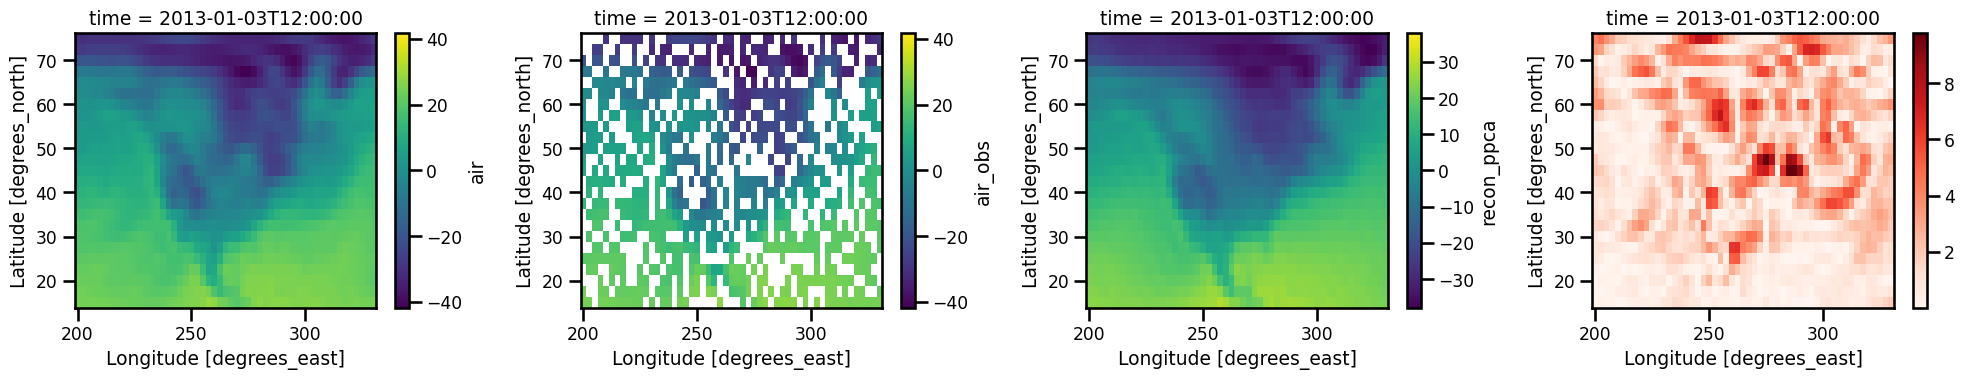

In [225]:
fig, ax = plt.subplots(ncols=4, figsize=(20,4))

itime = 10

ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
ds.air_obs.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
data.recon_ppca.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2], cmap="viridis")
np.abs(ds.air - data.recon_ppca).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[3],cmap="Reds")

plt.tight_layout()
plt.show()

In [24]:
B_t = np.cov(X, rowvar=False)
B_s = np.cov(X, rowvar=True)
_, W_s = localize_covariance(B_s, loc=50)

In [26]:
num_components = 50
num_iters = 100
err = 0.0
X = data.values.copy()

losses = []

pbar = trange(num_iters, desc='Reconstruction', leave=True)
for i in pbar:

    # extract inputs

    # apply PCA
    X_recon = pod_spatial_reconstruction(
        X=X.copy(), 
        n_components=num_components, 
        random_state=i, 
        localization=W_s
    )

    # set reconstructed values
    X_recon[non_nan_mask] = X[non_nan_mask]
    

    err_new = np.sqrt(np.mean(np.power(X[nan_mask] - X_recon[nan_mask], 2))) / X[non_nan_mask].std()
    rel_error = abs(err_new - err)
    pbar.set_postfix(error=err_new, rel_error=abs(err_new - err))
    
    losses.append(err_new)

    
    if rel_error < 1e-10:
        break

    err = err_new
    X = X_recon.copy()

Reconstruction:   0%|          | 0/100 [00:00<?, ?it/s]

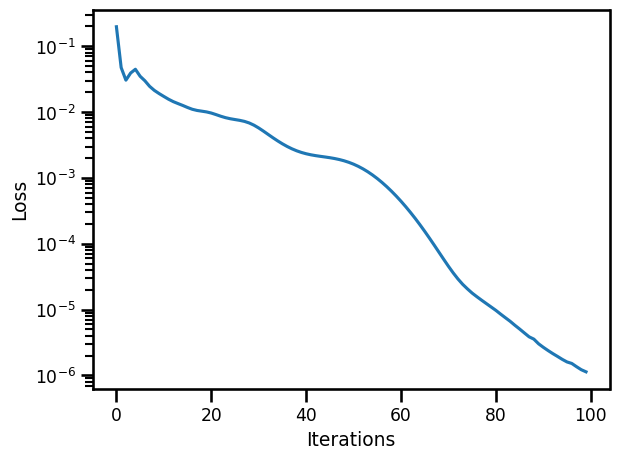

In [27]:
fig, ax = plt.subplots()

ax.plot(losses)

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.tight_layout()
plt.show()

In [28]:
ds["air_new"] = (("spatial", "time"), X)

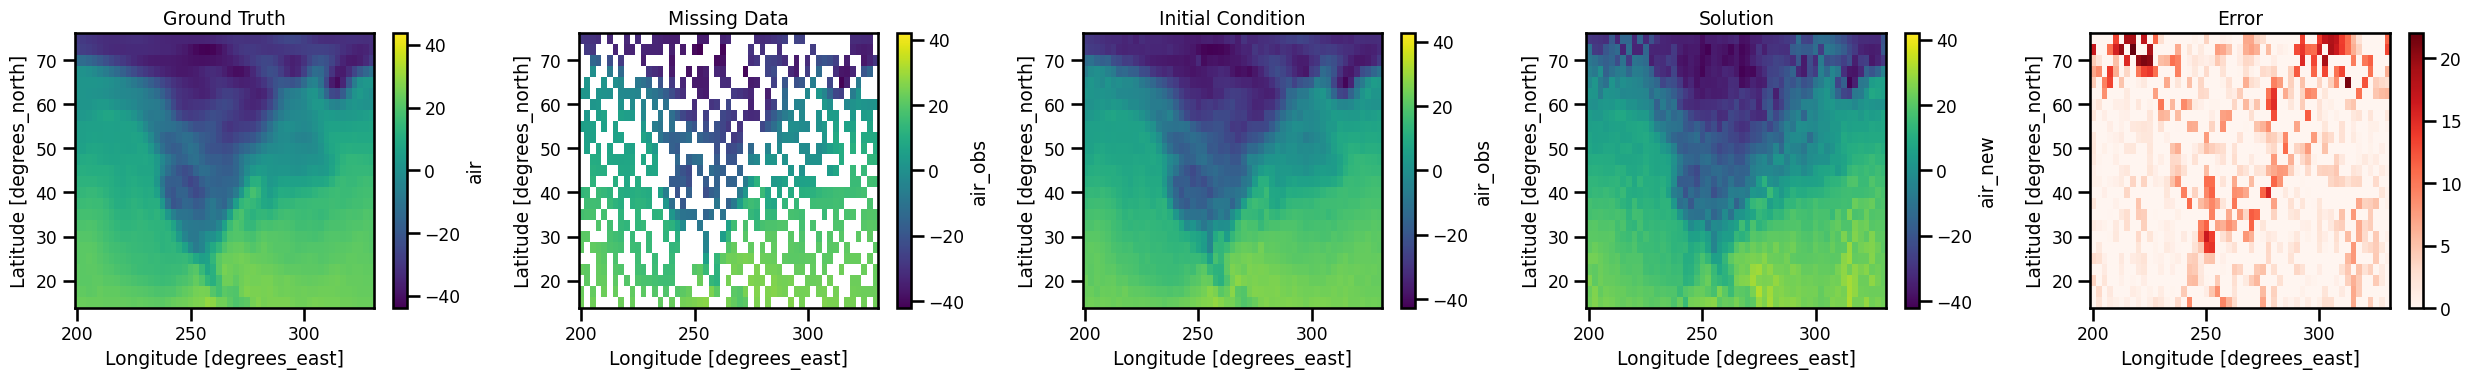

In [29]:
fig, ax = plt.subplots(ncols=5, figsize=(25,4))

itime = 50

ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
ds.air_obs.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
data.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2], cmap="viridis")
ds.air_new.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[3], cmap="viridis")
np.abs(ds.air.isel(time=itime) - ds.air_new.isel(time=itime)).unstack().plot.pcolormesh(x="lon",ax=ax[4],cmap="Reds")

ax[0].set(title="Ground Truth")
ax[1].set(title="Missing Data")
ax[2].set(title="Initial Condition")
ax[3].set(title="Solution")
ax[4].set(title="Error")
plt.tight_layout()
plt.show()

## Multi-Components

In [133]:
data = ds["air_obs"]

data = data.transpose("spatial", "time")

In [134]:
nan_mask = np.isnan(data)
non_nan_mask = ~nan_mask

# data = data.fillna(value=0.0)
data = data.interpolate_na(dim="time", method="slinear", fill_value="extrapolate")

X = data.values

In [135]:
num_iters = 1_000
num_components = [1, 5, 10, 20, 30, 40, 50]

In [136]:
X.shape

(1325, 2920)

In [137]:
X = data.values
pbar_components = tqdm(num_components, desc="Components")


err = 0.0
losses = []
X_recons = {}
for n in pbar_components:
    pbar = trange(num_iters, desc='Reconstruction', leave=False)
    for i in pbar:

        # extract inputs

        # apply PCA
        clf = PCA(n_components=n, random_state=i, svd_solver="randomized")
        clf.fit(X=X)

        # calculate reconstruction
        X_red = clf.transform(X)
        X_recon = clf.inverse_transform(X_red)

        # set non reconstructed values
        X_recon[non_nan_mask] = X[non_nan_mask]

        err_new = np.sqrt(np.mean(np.power(X[nan_mask] - X_recon[nan_mask], 2))) / X[non_nan_mask].std()
        
        rel_error = abs(err_new - err)
        pbar.set_postfix(error=err_new, rel_error=rel_error)
        losses.append(err_new)
        if rel_error < 1e-10:
            break

        err = err_new
        X = X_recon
        X_recons[n] = X.copy()
    pbar_components.set_postfix(error=err_new, rel_error=abs(err_new - err))


Components:   0%|          | 0/7 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

Reconstruction:   0%|          | 0/1000 [00:00<?, ?it/s]

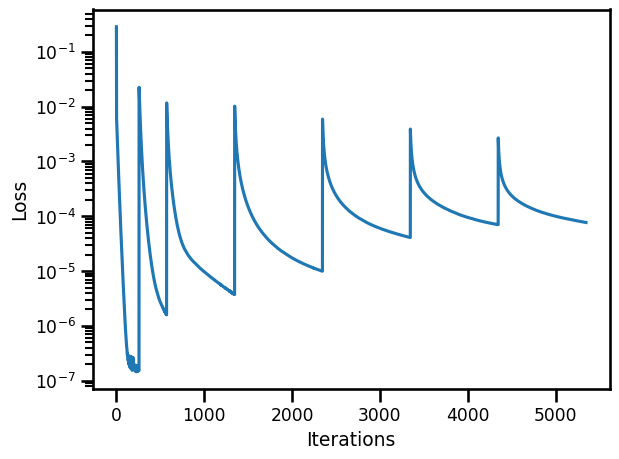

In [138]:
fig, ax = plt.subplots()

ax.plot(losses)

ax.set(xlabel="Iterations", ylabel="Loss", yscale="log")

plt.tight_layout()
plt.show()

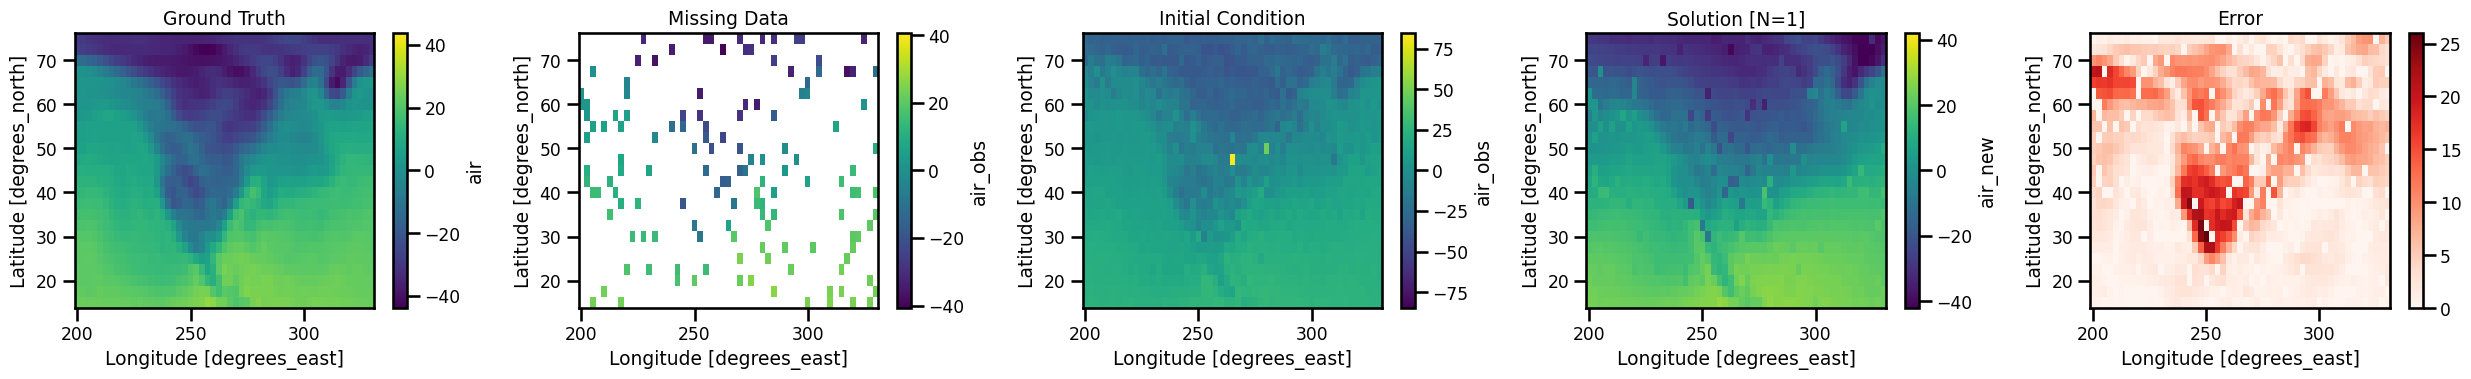

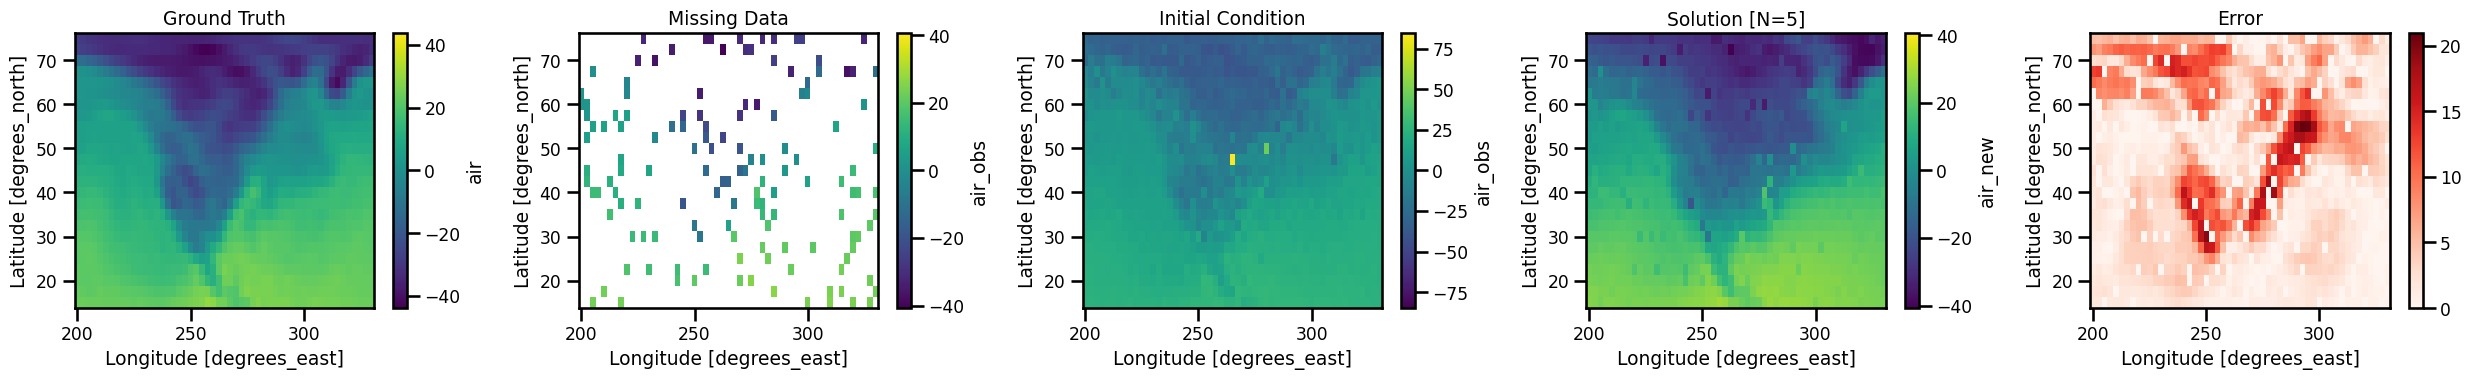

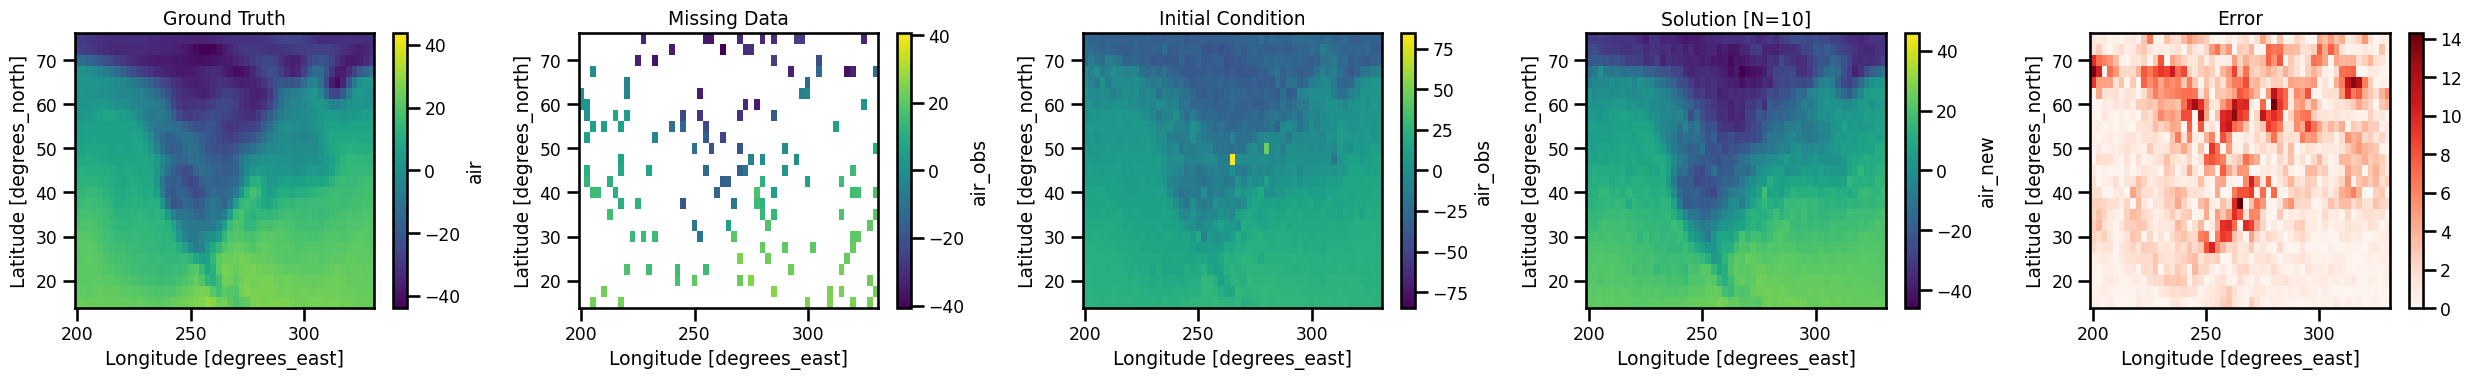

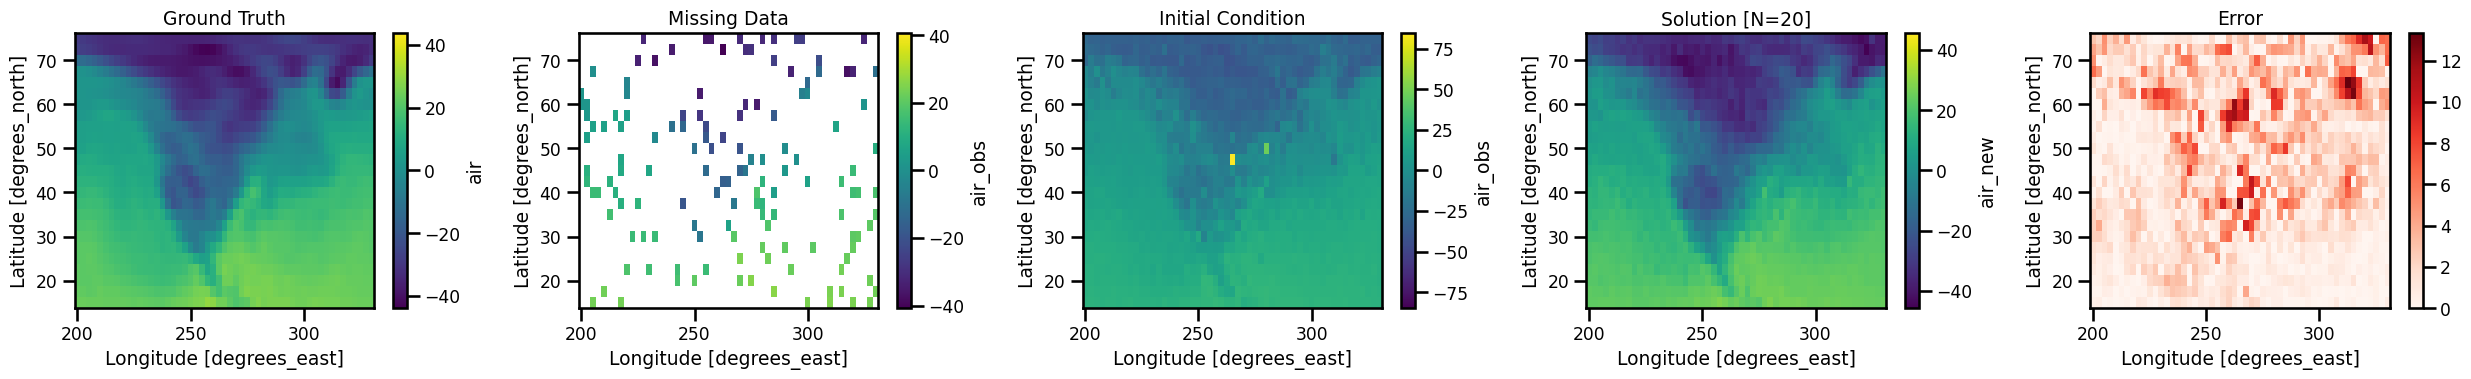

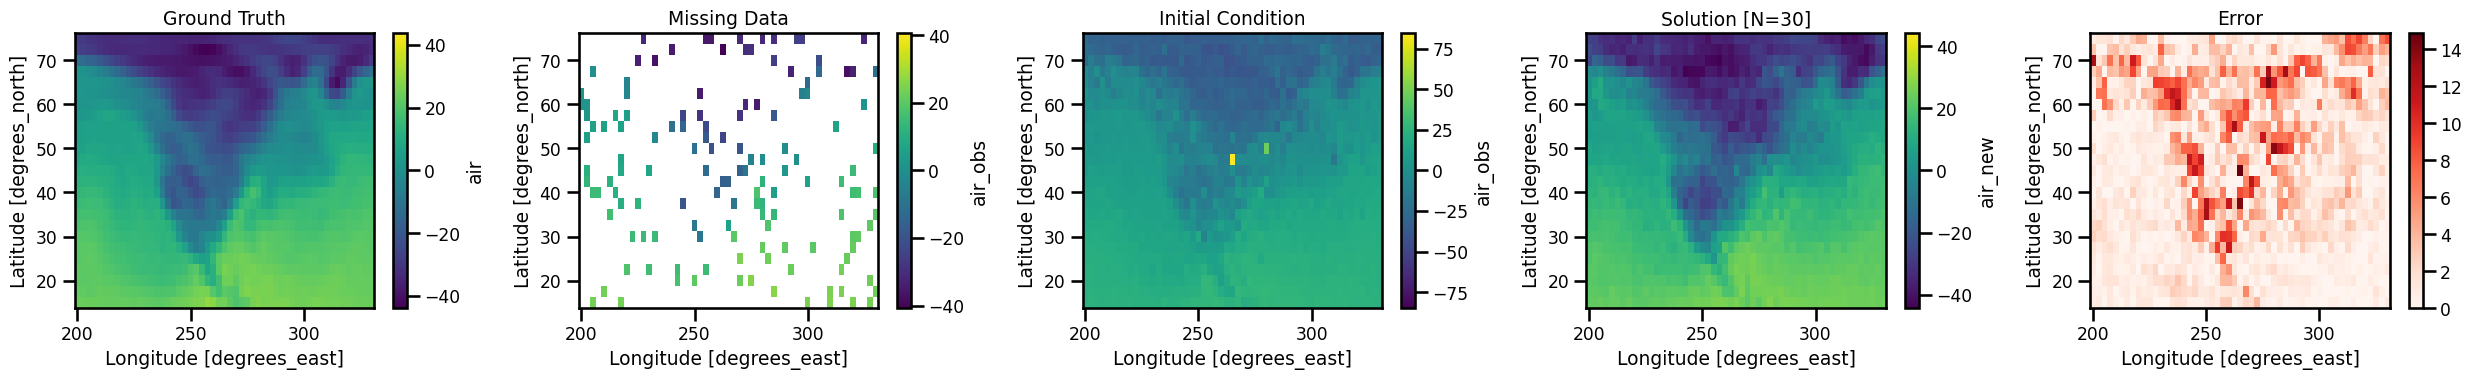

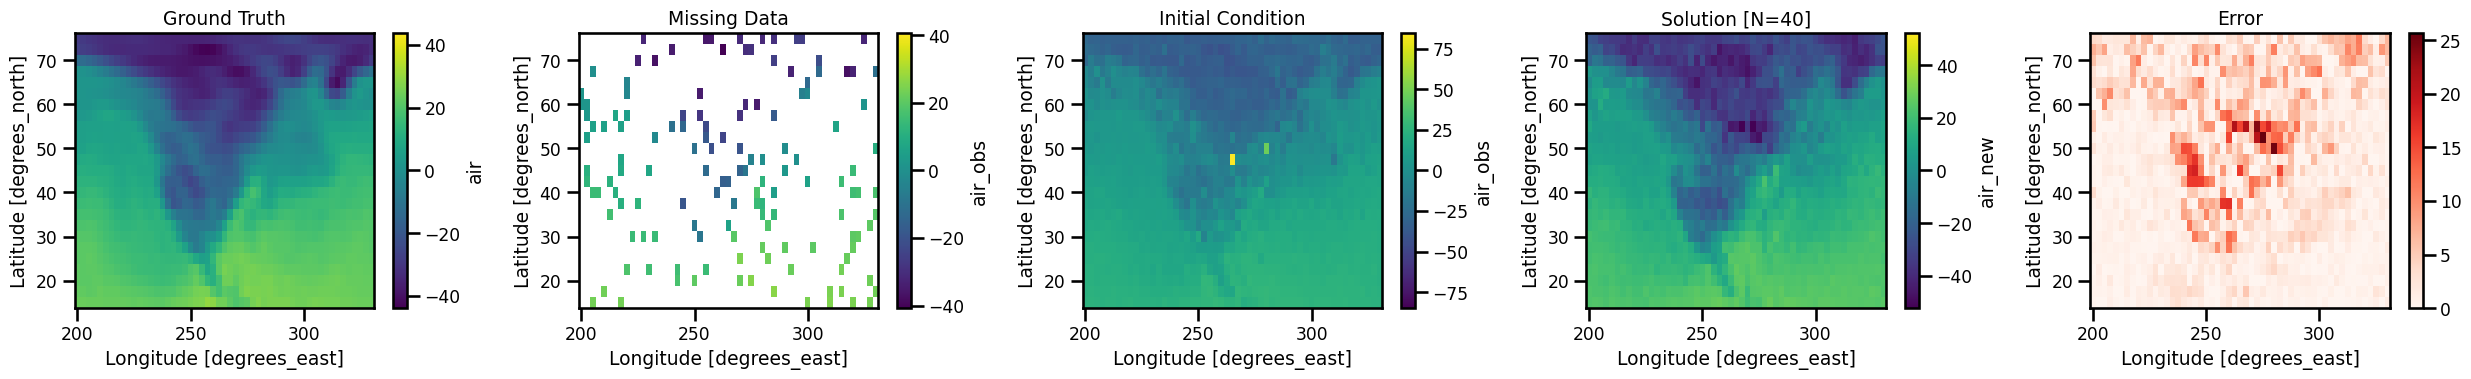

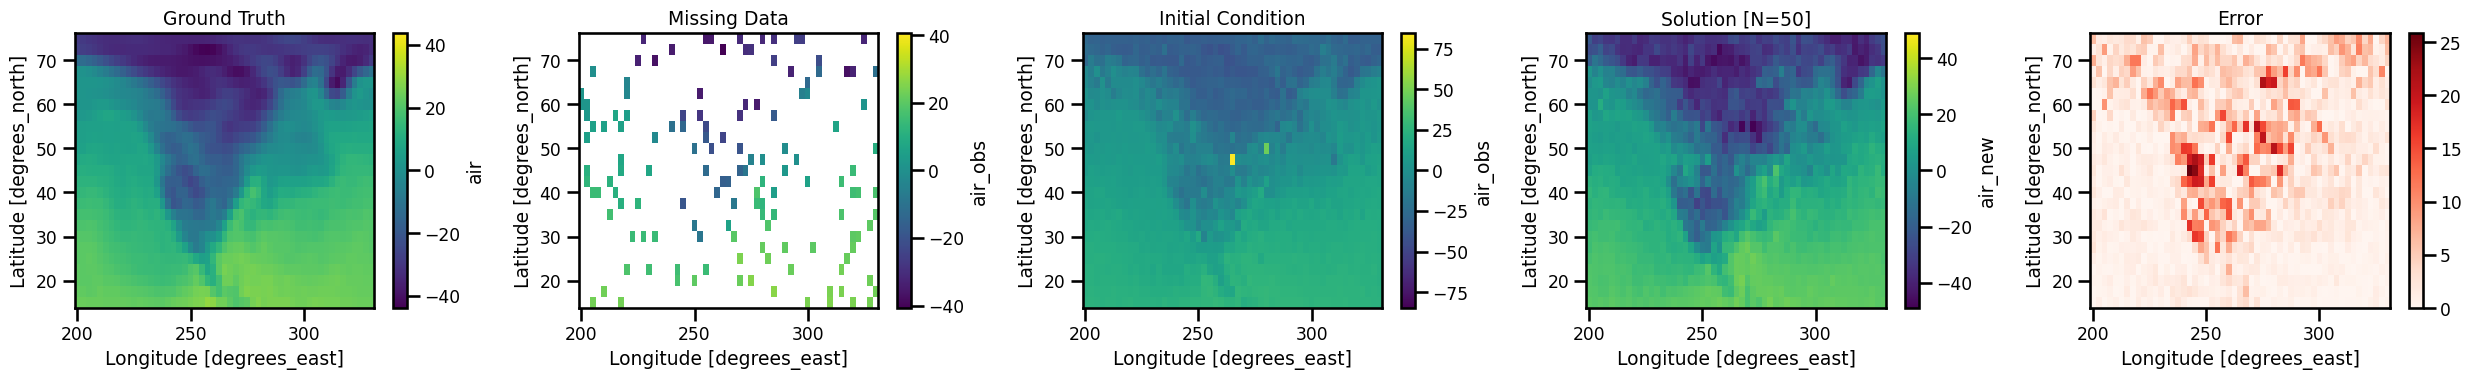

In [139]:

for i in num_components:

    fig, ax = plt.subplots(ncols=5, figsize=(25,4))

    ds["air_new"] = (("spatial", "time",), X_recons[i])

    itime = 50

    ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
    ds.air_obs.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
    data.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2], cmap="viridis")
    ds.air_new.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[3], cmap="viridis")
    np.abs(ds.air.isel(time=itime) - ds.air_new.isel(time=itime)).unstack().plot.pcolormesh(x="lon",ax=ax[4],cmap="Reds")

    ax[0].set(title="Ground Truth")
    ax[1].set(title="Missing Data")
    ax[2].set(title=f"Initial Condition")
    ax[3].set(title=f"Solution [N={i}]")
    ax[4].set(title="Error")
    plt.tight_layout()
    plt.show()

In [186]:
data = X

In [187]:
data

array([[ 0.0000000e+00, -7.0252338e-07,  0.0000000e+00, ...,
         0.0000000e+00,  2.3763764e-06,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-4.3705229e-05,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  2.5476020e-06,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  2.3763835e-06,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -1.5606513e-06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.6350427e-06,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [174]:
err

1.098653

In [396]:
clf.fit(X=data.values)

X_red = clf.transform(data.values)
X_recon = clf.inverse_transform(X_red)

In [144]:
ds.air_obs.max()

<xarray.DataArray 'air_obs' ()>
array(42.63998413)

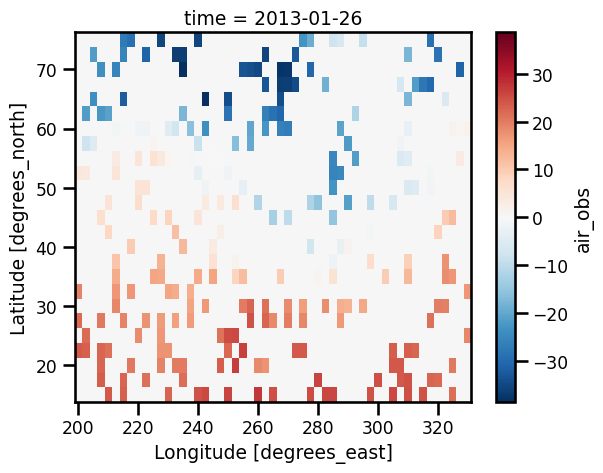

In [145]:
ds.air_obs.isel(time=itime).plot.pcolormesh()

In [ ]:
nan_mask = np.logical_and(np.isnan(ds["air_mask"]), self.mask)

In [ ]:
# Initial guess
nan_mask = np.logical_and(np.isnan(mat), self.mask)
non_nan_mask = np.logical_and(~nan_mask, self.mask)
mat[nan_mask] = 0
# Outside of an investigated area everything is considered to be zero
mat[self.inverse_mask] = 0 

pbar = trange(self.nitemax, desc='Reconstruction')
conv_error = 0
energy_per_iter = []
for i in pbar:
    u, s, vt = svds(mat, k=self.K, tol=self.tol)

    # Save energy characteristics for this iteration
    if self.with_energy:
        energy_i = utils.calculate_mat_energy(mat, s)
        energy_per_iter.append(energy_i)

    mat_hat = u @ np.diag(s) @ vt
    mat_hat[non_nan_mask] = mat[non_nan_mask]
    mat_hat[self.inverse_mask] = 0

    new_conv_error = np.sqrt(np.mean(np.power(mat_hat[nan_mask] - mat[nan_mask], 2))) / mat[non_nan_mask].std()
    mat = mat_hat

    pbar.set_postfix(error=new_conv_error, rel_error=abs(new_conv_error - conv_error))

    grad_conv_error = abs(new_conv_error - conv_error)
    conv_error = new_conv_error

    logger.info(f'Error/Relative Error at iteraion {i}: {conv_error}, {grad_conv_error}')

    if self.early_stopping:
        break_condition = (conv_error <= self.toliter) or (grad_conv_error < self.toliter)
    else:
        break_condition = (conv_error <= self.toliter)

    if break_condition:              
        break


In [130]:
rng = np.random.RandomState(42)
sigma = 0.01

ds["air_obs"] = xr.full_like(ds.air, np.nan)

# percentage seen
indices = np.arange(0, len(ds["air"].values.ravel()))
num_points = len(indices)
percentage = 0.70
idx = rng.choice(indices, size=(int(percentage * len(indices)),))
idx

array([2219110, 2768307, 2229084, ..., 1834500, 2961244, 1577558])

In [85]:
ds["air"].min(), ds["air"].max()

(<xarray.DataArray 'air' ()>
 array(-52.1499939),
 <xarray.DataArray 'air' ()>
 array(44.25))

In [86]:
ds["air_noisy"].min(), ds["air_noisy"].max()

(<xarray.DataArray 'air_noisy' ()>
 array(-51.84992184),
 <xarray.DataArray 'air_noisy' ()>
 array(44.53718747))

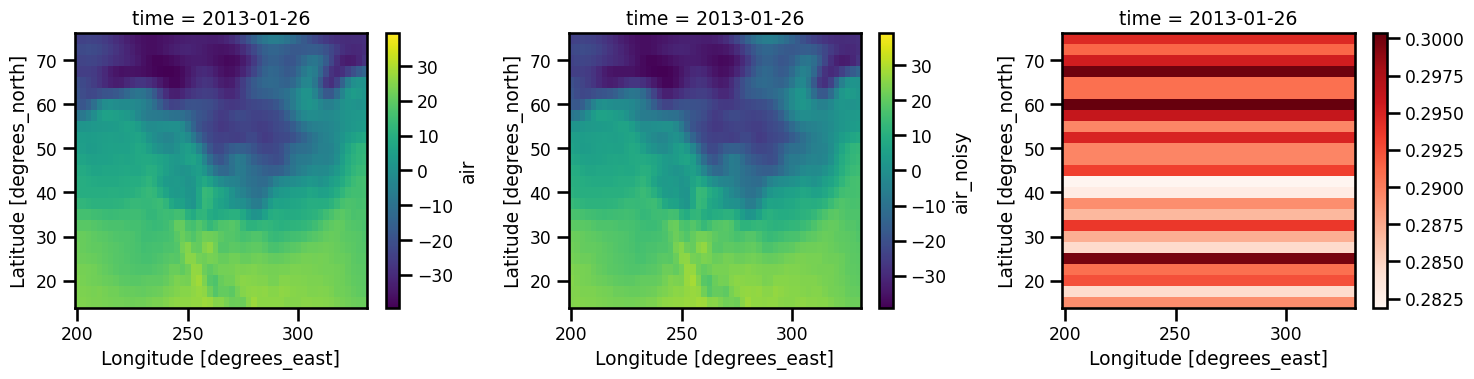

In [88]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 100

ds.air.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0], cmap="viridis")
ds.air_noisy.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1], cmap="viridis")
np.abs(ds.air.isel(time=itime) - ds.air_noisy.isel(time=itime)).unstack().plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

In [326]:
# change units
data = ds.air - 273.15

# tranpose
data = data.transpose("time", "lon", "lat")

# create sample dimensions
data = data.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")
n_space = data.spatial.shape[0]
n_time = data.time.shape[0]

In [395]:
n_components = 1 # 1_000

clf = PCA(n_components=n_components, random_state=42)

In [396]:
clf.fit(X=data.values)

X_red = clf.transform(data.values)
X_recon = clf.inverse_transform(X_red)

In [397]:
X_recon.shape, X_red.shape

((1325, 2920), (1325, 1))

In [398]:
out = data.to_dataset()
out["recon"] = (("spatial", "time"), np.real(X_recon))
out = out.unstack()

In [399]:
out.recon.min(), out.recon.max()

(<xarray.DataArray 'recon' ()>
 array(-47.47676086),
 <xarray.DataArray 'recon' ()>
 array(31.77927017))

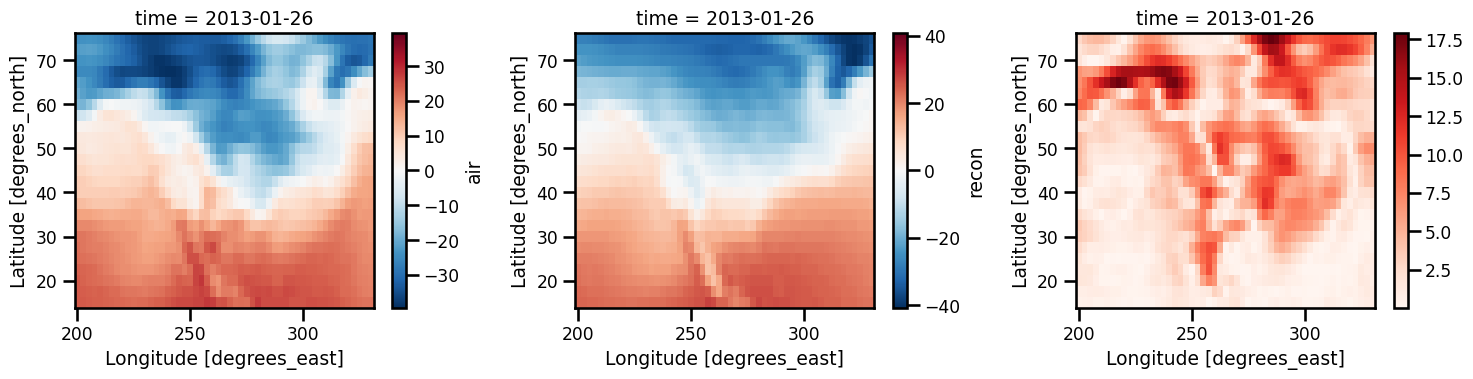

In [400]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 100

out.air.isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
out.recon.isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(out.air - out.recon).isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

## Missing Data

In [402]:
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## SVD

In [339]:
from sklearn.utils.extmath import randomized_svd, _randomized_eigsh

In [359]:
# change units
data = ds.air - 273.15

# tranpose
data = data.transpose("time", "lon", "lat")

# create sample dimensions
data = data.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")
n_space = data.spatial.shape[0]
n_time = data.time.shape[0]

In [360]:
# mean wrt time
data_mean = data.mean(dim=["time"])

# normalized data
data_norm = data - data_mean

# calculate covariance
data_cov = np.cov(data_norm.values, rowvar=False)
assert data_cov.shape == (n_time, n_time)

In [361]:
U, S, VT = randomized_svd(data_norm.values, n_components=n_components, random_state=42)

In [362]:
U.shape, S.shape, VT.shape

((1325, 1), (1,), (1, 2920))

In [363]:
X_recon = U @ np.diag(S) @ VT
X_recon = einx.add("Ns Nt, Ns -> Ns Nt", X_recon, data_mean.values)

In [364]:
out = data.to_dataset()
out["recon_svd"] = (("spatial", "time"), X_recon)
out = out.unstack()

In [365]:
out.recon_svd.min(), out.recon_svd.max()

(<xarray.DataArray 'recon_svd' ()>
 array(-40.29093933),
 <xarray.DataArray 'recon_svd' ()>
 array(33.78026962))

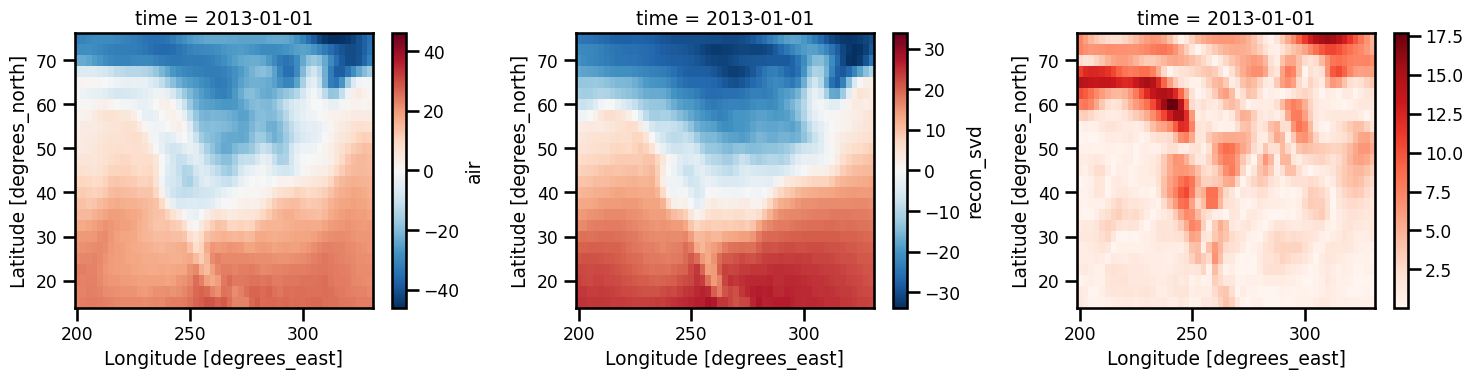

In [366]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

out.air.isel(time=0).plot.pcolormesh(x="lon", ax=ax[0])
out.recon_svd.isel(time=0).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(out.air - out.recon_svd).isel(time=0).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()

In [216]:
n_time = ds.time.shape[0]


# change units
data = ds.air - 273.15

# tranpose
data = data.transpose("time", "lon", "lat")

# create sample dimensions
data = data.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")
n_space = data.spatial.shape[0]

# mean wrt time
data_mean = data.mean(dim=["time"])

# normalized data
data_norm = data - data_mean
data_norm = data_norm.transpose("spatial", "time")

# calculate covariance
data_cov = np.cov(data_norm.values, rowvar=False)
assert data_cov.shape == (n_time, n_time)

# calculate eigenvalues
lam, phi = np.linalg.eig(data_cov, )
idx = np.argsort(lam)[::-1]
lam = lam[idx]
phi = phi[:, idx]

# calculate time coefficient
A = data_norm.values @ np.real(phi)

# reconstructin


In [218]:
data_cov.shape

(2920, 2920)

In [217]:
A.shape, phi.shape

((1325, 2920), (2920, 2920))

In [139]:
num_modes = None

In [148]:
A.shape, phi.shape

((1325, 2920), (2920, 2920))

In [149]:
data_norm_approx = np.einsum("ij,kj->ik",A[:, :num_modes],phi[:,:num_modes])

In [150]:
data_norm_approx.shape

(1325, 2920)

In [151]:
out = data.to_dataset()
out["modes"] = (("spatial", "time"), np.real(data_norm_approx))
out += data_mean
out = out.unstack()

In [152]:
out

<xarray.Dataset>
Dimensions:  (lon: 53, lat: 25, time: 2920)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lon, lat) float32 -44.72 -39.77 -31.53 ... 44.21 45.33 46.7
    modes    (time, lon, lat) float64 -32.21 -29.61 -23.41 ... 21.56 22.06 22.56

In [153]:
data_mean.shape, out.modes.shape

((1325,), (2920, 53, 25))

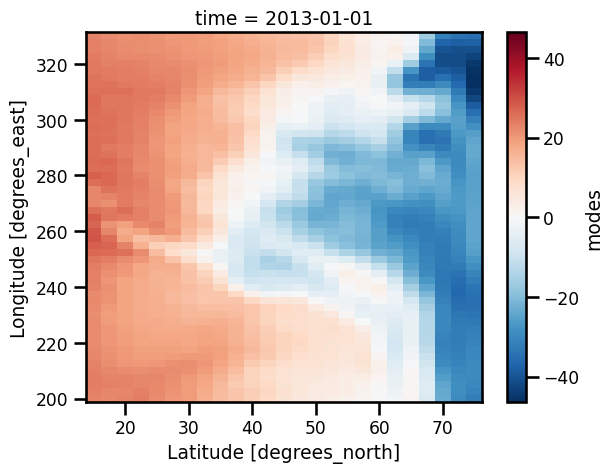

In [154]:
out.modes.isel(time=0).plot.pcolormesh()

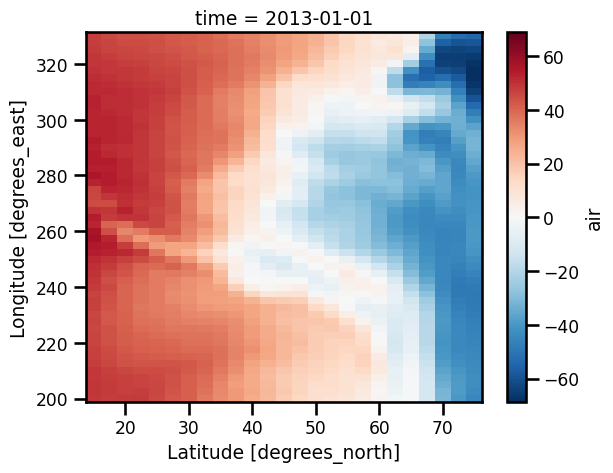

In [155]:
out.air.isel(time=0).plot.pcolormesh()

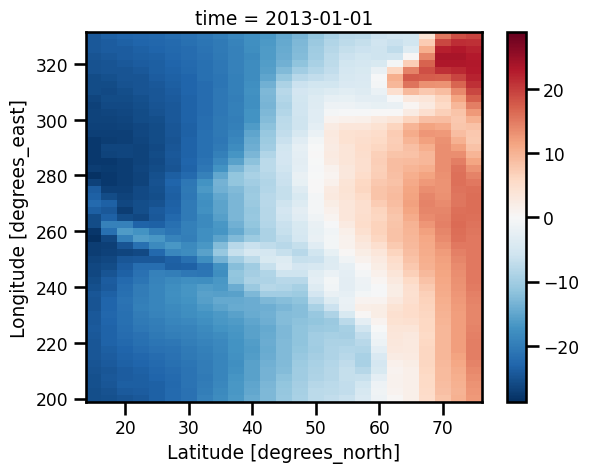

In [147]:
(out.modes - out.air).isel(time=0).plot.pcolormesh()

In [48]:
data_norm_approx.shape

(1325, 2920)

In [27]:
phi.shape, lam.shape

((1325,), (1325, 1325))

In [16]:
data_cov = np.cov(data_norm.values)
data_cov.shape

(1325, 1325)

In [9]:
data_cov = xr.cov(data_norm, data_norm, dim="time", )

In [10]:
data_cov.shape

(1325,)